In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import shapely

In [2]:
# read data and take a look

nyc_gdf = gpd.read_file('nycsquirrels_clean_1.csv')
nyc_gdf = gpd.GeoDataFrame(nyc_gdf, geometry=gpd.points_from_xy(nyc_gdf.long, nyc_gdf.lat))
nyc_gdf1 = nyc_gdf.set_crs('epsg:4326')

In [3]:
# create nyc_gdf2 which converts values into right format

long_float = nyc_gdf1['long'].apply(lambda x: float(x))
lat_float = nyc_gdf['lat'].apply(lambda x: float(x))

bool_to_int = lambda x: 1 if x == 'TRUE' else 0

approaches_int = nyc_gdf1['approaches'].apply(bool_to_int)
indifferent_int = nyc_gdf1['indifferent'].apply(bool_to_int)
runs_from_int = nyc_gdf1['runs_from'].apply(bool_to_int)

running_int = nyc_gdf1['running'].apply(bool_to_int)
chasing_int = nyc_gdf1['chasing'].apply(bool_to_int)
climbing_int = nyc_gdf1['climbing'].apply(bool_to_int)
eating_int = nyc_gdf1['eating'].apply(bool_to_int)
foraging_int = nyc_gdf1['foraging'].apply(bool_to_int)

kuks_int = nyc_gdf1['kuks'].apply(bool_to_int)
quaas_int = nyc_gdf1['quaas'].apply(bool_to_int)
moans_int = nyc_gdf1['moans'].apply(bool_to_int)
tail_flags_int = nyc_gdf1['tail_flags'].apply(bool_to_int)
tail_twitches_int = nyc_gdf1['tail_twitches'].apply(bool_to_int)

nyc_gdf2 = nyc_gdf1.assign(long = long_float,
                           lat = lat_float,
                           approaches = approaches_int,
                           indifferent=indifferent_int,
                           runs_from = runs_from_int,
                           running = running_int,
                           chasing = chasing_int,
                           climbing = climbing_int,
                           eating = eating_int,
                           foraging = foraging_int,
                           kuks = kuks_int,
                           quaas = quaas_int,
                           moans = moans_int,
                           tail_flags = tail_flags_int,
                           tail_twitches = tail_twitches_int)

## maps by hectare

In [4]:
# create nyc_gdf3 which gets proportion per hectare

nyc_gdf3 = nyc_gdf2.groupby('hectare').mean()

# series to get size of circle for each hectare

hectare_freq = nyc_gdf2.groupby('hectare').count().get('long')
nyc_gdf3['hectare_freq'] = hectare_freq
nyc_gdf3['hectare_freq_markersize'] = nyc_gdf3['hectare_freq'] * 10

# create geometry column (very important) and set projection again

nyc_gdf3 = gpd.GeoDataFrame(nyc_gdf3, geometry = gpd.points_from_xy(nyc_gdf3.long, nyc_gdf3.lat))
nyc_gdf3 = nyc_gdf3.set_crs('epsg:4326')

<AxesSubplot:>

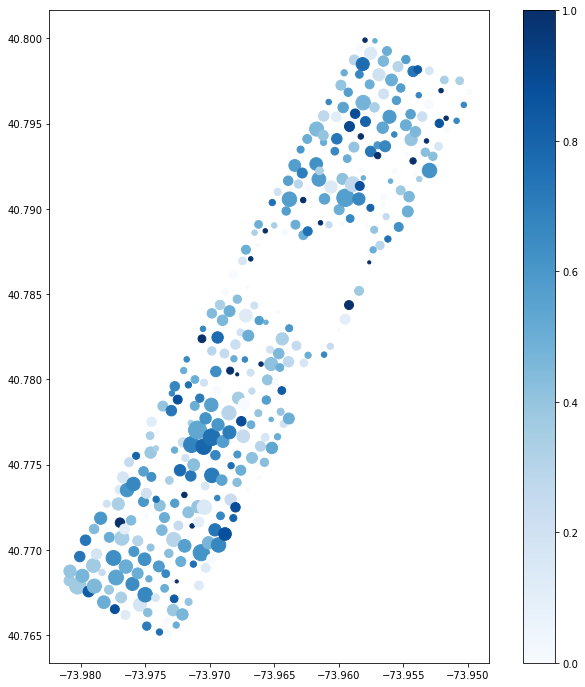

In [5]:
# plot by hectare! choose a column_name from the lists below

human_int = ['approaches', 'indifferent', 'runs_from']
movement = ['running', 'chasing', 'climbing', 'eating', 'foraging']
communication = ['kuks', 'quaas', 'moans', 'tail_flags', 'tail_twitches']

nyc_gdf3.plot(column = 'foraging',
              markersize = 'hectare_freq_markersize', 
              cmap = 'Blues',
              figsize = (12, 12),
              legend = True)

## osm maps

In [6]:
### load geojson datasets

centralpark_osm = gpd.read_file('geojson/centralpark.geojson')

# water bodies and streams
centralpark_water_osm = gpd.read_file('geojson/water_cp.geojson')
centralpark_stream_osm = gpd.read_file('geojson/streams_cp.geojson')

# playground
centralpark_playg_osm = gpd.read_file('geojson/playgrounds_cp.geojson')

# road (perimeter and inside)
centralpark_paved_osm = gpd.read_file('geojson/paved.geojson')

# toilets (buildings and points)
centralpark_toilets_osm = gpd.read_file('geojson/toilets.geojson')

# buildings (by section because too much data at once)
cp_northbd_osm = gpd.read_file('geojson/northbd.geojson') # cp north
cp_jorbd_osm = gpd.read_file('geojson/jorbd.geojson') # jacqueline kennedy onassis reservoir
cp_greatlawnbd_osm = gpd.read_file('geojson/greatlawnbd.geojson') # great lawn
cp_ramblebd_osm = gpd.read_file('geojson/ramblebd.geojson') # ramble
cp_southbd_osm = gpd.read_file('geojson/southbd.geojson') # cp south
met_osm = gpd.read_file('geojson/met.geojson') # the met

# gardens
centralpark_gardens_osm = gpd.read_file('geojson/gardens_cp.geojson')

# woods
allwoodsosm = gpd.read_file('geojson/woods_cp.geojson')

# baseball pitches (brown, inconsistent with fields/sports center)
cp_baseball_osm = gpd.read_file('geojson/baseballpitch.geojson')

# fields (open grassy areas)
cp_field_osm = gpd.read_file('geojson/field.geojson')

# bare rock (didn't know this was a thing)
allbarerockosm = gpd.read_file('geojson/bare_rock.geojson')

# remaining paved areas (The Mall, etc.)
cp_pedestrian_osm = gpd.read_file('geojson/pedestrian.geojson')

# sports center (tennis courts, recreation center)
cp_sportscenter_osm = gpd.read_file('geojson/sportscenter.geojson')

In [7]:
### cleaning up (clipping data by hand)

# allwaterosm

drop_water_osm = ['relation/2389611', 'relation/2389521', 'relation/2389581', 'relation/2389563', 
                  'relation/2212963', 'way/608955193', 
                  'way/375673047', 'way/375673046', 'way/1024586392',
                  'way/727185210', 'way/727185216', 'way/727185221', 'way/727185214', 
                  'way/113690622', 'way/163470962', 'way/260910559', 'way/319615314', 'way/319615316', 
                  'way/394395237', 'way/394395238', 'way/470714268', 'way/988718514', 'way/958630356']

drop_water_index = [centralpark_water_osm[centralpark_water_osm.get('id') == water_id].index[0] 
                    for water_id in drop_water_osm]

cp_water_osm = centralpark_water_osm.drop(index=drop_water_index)

allwaterosm = pd.concat([cp_water_osm, centralpark_stream_osm])
allwaterosm = allwaterosm.reset_index().drop(columns = 'index')


# allplaygosm

# filling in n/a values
centralpark_playg_osm.at[23, 'name'] = 'Rudin Family Playground'
centralpark_playg_osm.at[50, 'name'] = 'Safari Playground'

cp_playgrounds_name = ['West 110th Street Playground', 'Tarr Family Playground', 'Rudin Family Playground', 
                       'Robert Bendheim Playground', 'Tarr-Coyne Wild West Playground', '96th Street Playground', 
                       'Abraham and Joseph Spector Playground', 'Arthur Ross Pinetum Playground', 
                       'Diana Ross Playground', 'Ancient Playground', 'Safari Playground',
                       'Ruth and Arthur Smadbeck-Heckscher East Playground', 'Adventure Playground', 
                       'Tarr-Coyne Tots Playground', 'East 72nd Street Playground', 
                       'Billy Johnson Playground', 'Hecksher Playground', 'Mariner\'s Playground']

cp_playgrounds_index = [centralpark_playg_osm[centralpark_playg_osm.get('name') == playground_name].index[0]
                        for playground_name in cp_playgrounds_name]

allplaygosm = centralpark_playg_osm.loc[cp_playgrounds_index]


# allpavedosm

drop_paved_name = ['Park Avenue', 'Madison Avenue', 'Lexington Avenue', 'York Avenue', 'FDR Drive', 
                   'Riverside Drive', 'West End Avenue', 
                   'Frederick Douglass Boulevard', 'Malcolm X Boulevard',
                   '8th Avenue', '7th Avenue', '6th Avenue', 
                   'East 106th Street', 'East 97th Street', 'East 96th Street', 
                   'East 86th Street', 'East 85th Street', 'East 84th Street', 'East 79th Street',
                   'East 72nd Street', 'East 66th Street', 'East 65th Street',
                   'East 60th Street', 'East 59th Street',
                   'East 73rd Street', 'East 71st Street', 'East 61st Street',
                   'Cathedral Parkway', 'West 110th Street', 'West 106th Street', 'West 96th Street', 
                   'West 95th Street', 'West 86th Street', 'West 81st Street', 'West 79th Street', 
                   'West 75th Street', 'West 72nd Street', 'West 66th Street', 'West 65th Street',
                   'West 62nd Street', 'West 54th Street', 'West 53rd Street']

drop_paved_index = []

for name in drop_paved_name:
    index_list = centralpark_paved_osm[centralpark_paved_osm.get('name') == name].index
    for index in index_list:
        drop_paved_index.append(index)
        
drop_5th_ends = ['way/988984235', 'way/195743336', 'way/422298615', 'way/962626218', 'way/198924778',
                 'way/840996403', 'way/980855831', 'way/980855832', 'way/980855833', 'way/22898583',
                 'way/46613661', 'way/5670874', 'way/167922075', 
                 'way/584850094', 'way/834058007', 'way/5673363', 'way/584850099']

for way in drop_5th_ends:
    drop_paved_index.append(centralpark_paved_osm[centralpark_paved_osm.get('id') == way].index[0])
    

allpavedosm = centralpark_paved_osm.drop(index = drop_paved_index)


# alltoiletsosm

drop_toilets = ['node/2329911645', 'node/8539548031', 'node/1310874079', 'node/2339622631', 'way/266919662']

drop_toilets_index = [centralpark_toilets_osm[centralpark_toilets_osm.get('id') == node].index[0]
                      for node in drop_toilets]

alltoiletsosm = centralpark_toilets_osm.drop(index = drop_toilets_index)


# allbuildingosm

keepbd_columns = ['id', 'alt_name', 'amenity', 'building', 'height', 'name', 'geometry']

cp_northbd_id = ['way/39243913', 'way/278366155', 'way/278366170', 'way/118729389', 'way/943419152',
                 'way/278366166', 'way/278366163', 'way/278366174']
cp_northbd_index = [cp_northbd_osm[cp_northbd_osm.get('id') == northbd_id].index[0] for northbd_id in cp_northbd_id]
allnorthbdosm = cp_northbd_osm.loc[cp_northbd_index].get(keepbd_columns)

cp_jorbd_id = ['way/278363031', 'way/817397167', 'way/278363044']
cp_jorbd_index = [cp_jorbd_osm[cp_jorbd_osm.get('id') == jorbd_id].index[0] for jorbd_id in cp_jorbd_id]
alljorbdosm = cp_jorbd_osm.loc[cp_jorbd_index].get(keepbd_columns)

cp_greatlawnbd_id = ['way/278363039', 'way/278363038', 'way/278363033', 'way/278363041', 'way/278363029',
                     'way/278363036', 'way/278363065', 'way/278363049', 'way/278363046', 'way/278363024', 
                     'way/278363048', 'way/278363035', 'way/278363053']
cp_greatlawnbd_index = [cp_greatlawnbd_osm[cp_greatlawnbd_osm.get('id') == greatlawnbd_id].index[0] 
                        for greatlawnbd_id in cp_greatlawnbd_id]
allgreatlawnbdosm = cp_greatlawnbd_osm.loc[cp_greatlawnbd_index].get(keepbd_columns)

cp_ramblebd_id = ['way/278361406', 'way/278361407', 'way/775820359', 'relation/3698871', 
                  'way/354587581', 'way/354587583', 'way/265347581', 'way/265347585', 
                  'way/362647331', 'way/265347579', 'way/265347587']
cp_ramblebd_index = [cp_ramblebd_osm[cp_ramblebd_osm.get('id') == ramblebd_id].index[0] 
                     for ramblebd_id in cp_ramblebd_id]
allramblebdosm = cp_ramblebd_osm.loc[cp_ramblebd_index].get(keepbd_columns)

cp_southbd_id = ['way/265347589', 'way/585788256', 'way/265347597', 'way/265347588', 'way/265347593',
                 'way/321166650', 'way/321166649', 'way/265347596', 'way/265347590', 'way/265347591',
                 'way/385442739', 'way/265347586', 'way/265347592']
cp_southbd_index = [cp_southbd_osm[cp_southbd_osm.get('id') == southbd_id].index[0] 
                    for southbd_id in cp_southbd_id]
allsouthbdosm = cp_southbd_osm.loc[cp_southbd_index].get(keepbd_columns)

allmetosm = met_osm[met_osm.get('name') == 'The Metropolitan Museum of Art']

allbuildingosm = pd.concat([allnorthbdosm, alljorbdosm, allgreatlawnbdosm, 
                            allramblebdosm, allsouthbdosm, allmetosm])


# allgardenosm

drop_garden = ['way/362826846', 'way/169915675', 'way/330448922', 'way/313994014', 'way/202503285',
               'way/225189389', 'way/796333282', 'way/225188744']

drop_garden_index = [centralpark_gardens_osm[centralpark_gardens_osm.get('id') == way].index[0] 
                     for way in drop_garden]
    
allgardenosm = centralpark_gardens_osm.drop(index = drop_garden_index)


# allbaseballosm

drop_baseball = ['way/667343443', 'way/920569850', 'way/920569847', 'way/319797239']

drop_baseball_index = [cp_baseball_osm[cp_baseball_osm.get('id') == way].index[0] for way in drop_baseball]

allbaseballosm = cp_baseball_osm.drop(index = drop_baseball_index)


# allfieldosm

drop_field = ['way/188692199', 'way/951525207', 'way/951525216', 'way/951525219', 
              'way/951539223', 'way/951539207', 'way/951539204', 'way/951539221', 'way/951539203', 'way/951539215',
              'way/951539218', 'way/951525211', 'way/951539232', 'way/951525215', 'way/951525217',
              'way/951539196', 'way/951525222', 'way/951525209', 'way/972597724',
              'way/949457222', 'way/949457226', 'way/953189819', 'way/849307005', 'way/849307011', 'way/849307012',
              'way/849307006', 'way/952333244', 'way/849307009', 'way/953189823', 'way/952333240', 'way/949532332',
              'way/949848463', 'way/949851336', 'way/667981482', 'way/949848467', 'way/949848466',
              'way/833371440', 'way/949848471', 'way/949848459', 'way/949848457',
              'way/849046450', 'way/849046418', 'way/849046432', 'way/849046434', 'way/849046451',
              'way/849046431', 'way/849046424', 'way/849046433', 'way/849046423', 'way/667981479', 'way/667981483',
              'way/667981480', 'way/849046437', 'way/849046453', 'way/849046448', 'way/849046420',
              'way/849046440', 'way/849046435', 'way/849046417', 'way/849299252', 'way/849299251', 'way/949848465',
              'way/849046452', 'way/849046454', 'way/849046415', 'way/667981478', 'way/849046438', 'way/849046427',
              'way/849046421', 'way/849046429', 'way/849046457', 'way/849046428',
              'way/849046444', 'way/849046441', 'way/849046426', 'way/849046414', 'way/949848462']

drop_field_index = [cp_field_osm[cp_field_osm.get('id') == way].index[0] for way in drop_field]

allfieldosm = cp_field_osm.drop(index = drop_field_index)


# allpedestrianosm

drop_ped = ['relation/4623434', 'relation/4623433', 'relation/4623431', 'way/1031859264', 'way/321166645',
            'relation/2280942', 'way/329988122', 'way/329988123', 'way/458452177', 'way/710571385', 
            'way/375314249', 'way/338043682', 'way/46340036', 'way/710571377', 'way/5671777']

drop_ped_index = [cp_pedestrian_osm[cp_pedestrian_osm.get('id') == ped].index[0] for ped in drop_ped]

allpedestrianosm = cp_pedestrian_osm.drop(index=drop_ped_index)


# allspcenterosm

drop_spcenter = ['node/368062558', 'node/2724236668', 'node/5607297102']

drop_spcenter_index = [cp_sportscenter_osm[cp_sportscenter_osm.get('id') == spcenter].index[0] 
                       for spcenter in drop_spcenter]

allspcenterosm = cp_sportscenter_osm.drop(index=drop_spcenter_index)

In [85]:
### map all features with legend and tag

# allwaterosm
allwaterosm_keep = ['id', 'geometry', 'name', 'natural', 'waterway']
centralparkwater = allwaterosm[allwaterosm_keep]
feature_type = centralparkwater['natural'].fillna(centralparkwater['waterway'])
centralparkwater = centralparkwater.assign(feature_type = feature_type).drop(columns = ['natural', 'waterway'])
#centralparkwater = centralparkwater[centralparkwater.get('feature_type') == 'water']

# allpavedosm
allpavedosm_keep = ['id', 'geometry', 'name', 'highway', 'route']
centralparkpaved = allpavedosm[allpavedosm_keep].reset_index().drop(columns='index')
centralparkpaved = centralparkpaved.assign(feature_type = 'paved').drop(columns = ['highway', 'route'])

# allgardenosm
allgardenosm_keep = ['id', 'geometry', 'name', 'leisure']
centralparkgarden = allgardenosm[allgardenosm_keep]
centralparkgarden = centralparkgarden.assign(feature_type = 
                                             centralparkgarden.get('leisure')).drop(columns = 'leisure')

# allbaseballosm
allbaseball_keep = ['id', 'geometry', 'name', 'leisure', 'sport']
centralparkbaseball = allbaseballosm[allbaseball_keep]
centralparkbaseball = centralparkbaseball.assign(feature_type = 
                                                 'pitch: baseball').drop(columns = ['leisure', 'sport'])

# allwoodsosm
allwoods_keep = ['id', 'geometry', 'name', 'natural']
centralparkwoods = allwoodsosm[allwoods_keep]
centralparkwoods = centralparkwoods.assign(feature_type = 
                                           centralparkwoods.get('natural')).drop(columns = 'natural')

# allfieldsosm
allfields_keep = ['id', 'geometry', 'name', 'landuse']
centralparkfields = allfieldosm[allfields_keep]
centralparkfields = centralparkfields.assign(feature_type = 'grass').drop(columns = 'landuse')

# allplaygosm
allplayg_keep = ['id', 'geometry', 'name', 'leisure']
centralparkplayg = allplaygosm[allplayg_keep]
centralparkplayg = centralparkplayg.assign(feature_type = 'playground').drop(columns = 'leisure')

# allbuildingosm
allbuild_keep = ['id', 'geometry', 'name', 'building']
centralparkbuilding = allbuildingosm[allbuild_keep]
centralparkbuilding = centralparkbuilding.assign(feature_type = 'building').drop(columns = 'building')

# allspcenterosm
allspcenter_keep = ['id', 'geometry', 'name', 'leisure']
centralparkspcenter = allspcenterosm[allspcenter_keep]
centralparkspcenter = centralparkspcenter.assign(feature_type = 'sports center').drop(columns = 'leisure')

#allpedestrianosm
allped_keep = ['id', 'geometry', 'name', 'highway']
centralparkpedestrian = allpedestrianosm[allped_keep]
centralparkpedestrian = centralparkpedestrian.assign(feature_type = 'pedestrian').drop(columns = 'highway')

# allbarerockosm
allrock_keep = ['id', 'geometry', 'name', 'natural']
centralparkrock = allbarerockosm[allrock_keep]
centralparkrock = centralparkrock.assign(feature_type = 'bare_rock').drop(columns = 'natural')

# alltoiletsosm
alltoilet_keep = ['id', 'geometry', 'name', 'amenity']
centralparktoilet = alltoiletsosm[alltoilet_keep]
centralparktoilet = centralparktoilet.assign(feature_type = 'toilet').drop(columns = 'amenity')

centralparkfeatures = pd.concat([centralparkgarden, centralparkwater, centralparkfields, 
                                 centralparkwoods, centralparkbaseball, centralparkplayg,
                                 centralparkpaved, centralparkbuilding, centralparkspcenter,
                                 centralparkpedestrian, centralparkrock, centralparktoilet])

centralparkfeaturescmap = ['#6b6865', '#ad6f03', '#ff8cec', '#86b35d', '#000000', '#000000', '#c4a782', '#d96866',
                           '#960906', '#1795e8', '#737373', '#1795e8', '#098f57']

centralparkfeaturesmap = centralparkfeatures.explore(column='feature_type',
                                                     tooltip=['feature_type', 'name'],
                                                     popup=True,
                                                     tiles="cartodbpositron",
                                                     cmap = centralparkfeaturescmap,
                                                     max_zoom = 10)

centralparkfeaturesmap

In [86]:
# map only significant features

cpfeatures_short = pd.concat([centralparkgarden, centralparkwater, centralparkfields, centralparkwoods, 
                              centralparkbuilding, centralparkpedestrian])

cpfeatures_shortcmap = ['#ad6f03', '#ff8cec', '#86b35d', '#000000', '#1795e8', '#098f57']

cpfeatures_shortmap = cpfeatures_short.explore(column='feature_type',
                                               tooltip=['feature_type', 'name'],
                                               popup=True,
                                               tiles="cartodbpositron",
                                               cmap=cpfeatures_shortcmap)

cpfeatures_shortmap

## osm map gis analysis

In [87]:
### areas where squirrels may be found

# centralparkrock
geom_cprock_union = centralparkrock.geometry.unary_union
squirrelinrock = nyc_gdf2.within(geom_cprock_union)

# centralparkgarden
geom_cpgarden_union = centralparkgarden.geometry.unary_union
squirrelingarden = nyc_gdf2.within(geom_cpgarden_union)

# centralparkgrass
geom_cpfields_union = centralparkfields.geometry.unary_union
squirrelinfields = nyc_gdf2.within(geom_cpfields_union)

# centralparkpedestrian
geom_cppedestrian_union = centralparkpedestrian.geometry.unary_union
squirrelinpedestrian = nyc_gdf2.within(geom_cppedestrian_union)

# centralparkbaseball
geom_cpbaseball_union = centralparkbaseball.geometry.unary_union
squirrelinbaseball = nyc_gdf2.within(geom_cpbaseball_union)

# centralparkplayground
geom_cpplayg_union = centralparkplayg.geometry.unary_union
squirrelinplayg = nyc_gdf2.within(geom_cpplayg_union)

# centralparkwood
geom_cpwoods_union = centralparkwoods.geometry.unary_union
squirrelinwoods = nyc_gdf2.within(geom_cpwoods_union)


### areas where squirrels are expected to not be found

# centralparkbuilding
geom_cpbuild_union = centralparkbuilding.geometry.unary_union
squirrelinbuilding = nyc_gdf2.within(geom_cpbuild_union)

# centralparkspcenter
geom_cpspcenter_union = centralparkspcenter.geometry.unary_union
squirrelinspcenter = nyc_gdf2.within(geom_cpspcenter_union)

# centralparkwater
geom_cpwater_union = centralparkwater.geometry.unary_union
squirrelinwater = nyc_gdf2.within(geom_cpwater_union)

# centralparktoilet
geom_cptoilet_union = centralparktoilet.geometry.unary_union
squirrelintoilet = nyc_gdf2.within(geom_cptoilet_union)

In [88]:
centralparkwater

,id,geometry,name,feature_type
0,relation/166150,"POLYGON ((-73.96793 40.77998, -73.96795 40.779...",Turtle Pond,water
1,relation/2155107,"POLYGON ((-73.95423 40.79692, -73.95416 40.796...",Harlem Meer,water
2,relation/7895705,"POLYGON ((-73.96911 40.77493, -73.96889 40.775...",The Lake,water
3,way/6678417,"POLYGON ((-73.96124 40.78883, -73.96132 40.788...",Jacqueline Kennedy Onassis Reservoir,water
4,way/22726524,"POLYGON ((-73.97375 40.76569, -73.97374 40.765...",The Pond,water
5,way/22886740,"POLYGON ((-73.96726 40.77373, -73.96718 40.773...",Conservatory Water,water
6,way/37183391,"POLYGON ((-73.96171 40.79491, -73.96173 40.794...",The Pool,water
7,way/108111417,"POLYGON ((-73.97182 40.76840, -73.97182 40.768...",None,water
8,way/108111423,"POLYGON ((-73.97182 40.76792, -73.97189 40.767...",None,water
9,way/108111435,"POLYGON ((-73.97243 40.76811, -73.97244 40.768...",None,water


In [118]:
### buffers around water and building

# project to a projected CRS for accuracy (instead of a geographic CRS)
nyc_gdf2_2263 = nyc_gdf2.to_crs('epsg:2263')
centralparkwater_2263 = centralparkwater.to_crs('epsg:2263')
water_buffer = centralparkwater_2263.geometry.buffer(100).unary_union
squirrelinwaterbuffer = nyc_gdf2_2263.within(water_buffer)

centralparkwoods_2263 = centralparkwoods.to_crs('epsg: 2263')
woods_buffer = centralparkwoods_2263.geometry.buffer(100).unary_union
squirrelinwoodsbuffer = nyc_gdf2_2263.within(woods_buffer)

centralparkgrass_2263 = centralparkfields.to_crs('epsg: 2263')
grass_buffer = centralparkgrass_2263.geometry.buffer(100).unary_union
squirrelingrassbuffer = nyc_gdf2_2263.within(grass_buffer)

nyc_gdf5 = nyc_gdf2.assign(nearwater = squirrelinwaterbuffer)
nyc_gdf5 = nyc_gdf5.assign(nearwoods = squirrelinwoodsbuffer)
nyc_gdf5 = nyc_gdf5.assign(neargrass = squirrelingrassbuffer)
squirrelnearwater = nyc_gdf5[nyc_gdf5.get('nearwater') == True]
squirrelnearwoods = nyc_gdf5[nyc_gdf5.get('nearwoods') == True]
squirrelneargrass = nyc_gdf5[nyc_gdf5.get('neargrass') == True]

#folium.LayerControl().add_to(cpfeatures_shortmap)
#squirrelnearwater.explore(m = cpfeatures_shortmap)
squirrelnearwater = nyc_gdf5[nyc_gdf5.get('nearwater') == True]
squirrelnearwater.explore()

In [119]:
### remove squirrels outside central park

centralpark_perimeter = centralparkpaved[(centralparkpaved.get('name') == '5th Avenue') |
                                         (centralparkpaved.get('name') == 'Central Park North') |
                                         (centralparkpaved.get('name') == 'Central Park West') |
                                         (centralparkpaved.get('name') == 'Central Park South') |
                                         (centralparkpaved.get('name') == 'Grand Army Plaza') |
                                         (centralparkpaved.get('name') == 'Doris C. Freedman Place') |
                                         (centralparkpaved.get('name') == 'Duke Ellington Circle')]

centralparkperimeter = centralpark_perimeter.unary_union.convex_hull

squirrelinside = nyc_gdf2.within(centralparkperimeter)

nyc_gdf4 = nyc_gdf2.assign(inrock = squirrelinrock,
                           ingarden = squirrelingarden,
                           infields = squirrelinfields,
                           inpedestrian = squirrelinpedestrian,
                           inbaseball = squirrelinbaseball,
                           inplayg = squirrelinplayg,
                           inwoods = squirrelinwoods,
                           inbuilding = squirrelinbuilding,
                           inspcenter = squirrelinspcenter,
                           inwater = squirrelinwater,
                           intoilet = squirrelintoilet,
                           inside = squirrelinside)

nyc_gdf4 = nyc_gdf4[nyc_gdf4.get('inside') == True]
nyc_gdf4

,long,lat,unique_squirrel_id,hectare,shift,date,hectare_squirrel_number,age,primary_fur_color,combination_of_primary_and_highlight_color,...,infields,inpedestrian,inbaseball,inplayg,inwoods,inbuilding,inspcenter,inwater,intoilet,inside
0,-73.957044,40.794851,37E-PM-1006-03,37E,PM,10062018,3,Adult,Gray,Gray+Cinnamon,...,False,False,False,False,True,False,False,False,False,True
1,-73.976831,40.766718,2E-AM-1010-03,02E,AM,10102018,3,Adult,Cinnamon,Cinnamon+,...,False,False,False,False,False,False,False,False,False,True
2,-73.975725,40.769703,5D-PM-1018-05,05D,PM,10182018,5,Juvenile,Gray,Gray+,...,False,False,False,False,False,False,False,False,False,True
3,-73.956570,40.790256,33H-AM-1019-02,33H,AM,10192018,2,Juvenile,Gray,Gray+Cinnamon,...,True,False,False,False,False,False,False,False,False,True
4,-73.971974,40.769305,6G-PM-1020-02,06G,PM,10202018,2,Adult,Gray,Gray+,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2963,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,Gray+,...,False,False,False,False,False,False,False,False,False,True
2964,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,Gray+White,...,False,False,False,False,False,False,False,False,False,True
2965,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Gray+Black, Cinnamon, White",...,False,False,False,False,True,False,False,False,False,True
2966,-73.963994,40.789915,29B-PM-1010-02,29B,PM,10102018,2,,Gray,"Gray+Cinnamon, White",...,False,False,False,False,False,False,False,False,False,True


In [120]:
cpfeatures_short[cpfeatures_short.get('feature_type') == 'garden']
cpfeatures_short = cpfeatures_short.drop(index=[13, 14, 15])
cpfeatures_short

KeyError: '[13 14 15] not found in axis'

# clean up from here

In [121]:
cpfeatures_short[cpfeatures_short.get('feature_type') == 'garden']

,id,geometry,name,feature_type
7,way/385460488,"POLYGON ((-73.97248 40.76996, -73.97249 40.769...",Olmsted Flower Bed,garden
8,way/385460489,"POLYGON ((-73.96965 40.76918, -73.96855 40.770...",The Dene,garden
9,way/387351390,"POLYGON ((-73.95315 40.79403, -73.95320 40.793...",Conservatory Garden,garden
10,way/426373514,"POLYGON ((-73.97369 40.77248, -73.97368 40.772...",Nell Singer Lilac Walk,garden
11,way/429887431,"POLYGON ((-73.96988 40.77998, -73.96995 40.779...",Shakespeare Garden,garden


In [122]:
type(water_buffer)
water_buffer_geojson = [{'type': 'Feature', 'properties': {}, 'geometry': shapely.geometry.mapping(water_buffer)}]

In [123]:
import pyproj
from shapely.ops import transform

buffercrs = pyproj.CRS('epsg: 2263')
regcrs = pyproj.CRS('epsg: 4326')

project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy = True).transform
waterbufferwgs84 = transform(project, water_buffer)
woodsbufferwgs84 = transform(project, woods_buffer)
woodsbufferwgs84
grassbufferwgs84 = transform(project, grass_buffer)

In [124]:
centralparkwater.to_crs('epsg:2263').to_crs('epsg:4326')

,id,geometry,name,feature_type
0,relation/166150,"POLYGON ((-73.96793 40.77998, -73.96795 40.779...",Turtle Pond,water
1,relation/2155107,"POLYGON ((-73.95423 40.79692, -73.95416 40.796...",Harlem Meer,water
2,relation/7895705,"POLYGON ((-73.96911 40.77493, -73.96889 40.775...",The Lake,water
3,way/6678417,"POLYGON ((-73.96124 40.78883, -73.96132 40.788...",Jacqueline Kennedy Onassis Reservoir,water
4,way/22726524,"POLYGON ((-73.97375 40.76569, -73.97374 40.765...",The Pond,water
5,way/22886740,"POLYGON ((-73.96726 40.77373, -73.96718 40.773...",Conservatory Water,water
6,way/37183391,"POLYGON ((-73.96171 40.79491, -73.96173 40.794...",The Pool,water
7,way/108111417,"POLYGON ((-73.97182 40.76840, -73.97182 40.768...",None,water
8,way/108111423,"POLYGON ((-73.97182 40.76792, -73.97189 40.767...",None,water
9,way/108111435,"POLYGON ((-73.97243 40.76811, -73.97244 40.768...",None,water


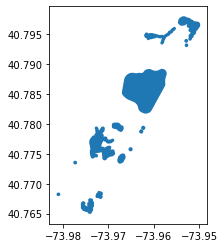

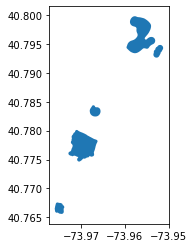

In [125]:
waterbufferwgs84df = gpd.GeoDataFrame(waterbufferwgs84)
geoms = waterbufferwgs84df.get(0)
waterbufferwgs84df = waterbufferwgs84df.assign(geometry = geoms).drop(columns=0)
waterbufferwgs84df = waterbufferwgs84df.set_crs('epsg:4326', inplace=True)
waterbufferwgs84df.plot()

woodsbufferwgs84df = gpd.GeoDataFrame(woodsbufferwgs84)
geomswoods = woodsbufferwgs84df.get(0)
woodsbufferwgs84df = woodsbufferwgs84df.assign(geometry = geomswoods).drop(columns=0)
woodsbufferwgs84df = woodsbufferwgs84df.set_crs('epsg:4326', inplace=True)
woodsbufferwgs84df.plot()

grassbufferwgs84df = gpd.GeoDataFrame(grassbufferwgs84)
geomsgrass = grassbufferwgs84df.get(0)
grassbufferwgs84df = grassbufferwgs84df.assign(geometry = geomsgrass).drop(columns=0)
grassbufferwgs84df = grassbufferwgs84df.set_crs('epsg:4326', inplace=True)

In [126]:
cpimap = folium.Map(location = [40.7835, -73.96600], zoom_start = 14, tiles = 'cartodbpositron')

style_functions = lambda x: {'stroke': False, 
                             'fillOpacity': 1.0,
                             'fillColor': '#098f57' if x['properties']['feature_type'] == 'wood' 
                             else '#1795e8' if x['properties']['feature_type'] == 'water'
                             else '#86b35d' if x['properties']['feature_type'] == 'grass'
                             else '#ad6f03' if x['properties']['feature_type'] == 'building'
                             else '#ff8cec' if x['properties']['feature_type'] == 'garden'
                             else '#000000'}

folium.GeoJson(cpfeatures_short, name='allcpfeatures', style_function=style_functions, overlay=False).add_to(cpimap)

# add individual feature layers
folium.GeoJson(centralparkwater, name='water', 
               style_function=lambda x: {'fillColor': '#1795e8', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)
folium.GeoJson(centralparkwoods, name='woods',
               style_function=lambda x: {'fillColor': '#098f57', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)
folium.GeoJson(centralparkfields, name='grass', 
               style_function=lambda x: {'fillColor': '#86b35d', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)
folium.GeoJson(centralparkgarden, name='garden',
               style_function=lambda x: {'fillColor': '#ff8cec', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)
folium.GeoJson(centralparkbuilding, name='building',
               style_function=lambda x: {'fillColor': '#ad6f03', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)
folium.GeoJson(centralparkpedestrian, name='pedestrain',
               style_function=lambda x: {'fillColor': '#000000', 'fillOpacity': 1.0, 'stroke':False}).add_to(cpimap)

# add buffers
folium.GeoJson(waterbufferwgs84df, name='water buffer', 
               style_function=lambda x: {'fillColor': '#1795e8', 'fillOpacity': 0.2, 'color': '#1795e8'}).add_to(cpimap)
folium.GeoJson(woodsbufferwgs84df, name='woods buffer',
               style_function=lambda x: {'fillColor': '#098f57', 'fillOpacity': 0.2, 'color': '#098f57'}).add_to(cpimap)
folium.GeoJson(grassbufferwgs84df, name='grass buffer',
               style_function=lambda x: {'fillColor': '#86b35d', 'fillOpacity': 0.2, 'color': '#86b35d'}).add_to(cpimap)

folium.LayerControl().add_to(cpimap)

cpimap

In [127]:
nyc_gdf5.columns

Index(['long', 'lat', 'unique_squirrel_id', 'hectare', 'shift', 'date',
       'hectare_squirrel_number', 'age', 'primary_fur_color',
       'combination_of_primary_and_highlight_color', 'location',
       'above_ground_sighter_measurement', 'running', 'chasing', 'climbing',
       'eating', 'foraging', 'kuks', 'quaas', 'moans', 'tail_flags',
       'tail_twitches', 'approaches', 'indifferent', 'runs_from', 'lat_long',
       'community_districts', 'borough_boundaries', 'city_council_districts',
       'police_precincts', 'geometry', 'nearwater', 'nearwoods', 'neargrass'],
      dtype='object')

In [128]:
nyc_gdf5 = nyc_gdf5.drop(columns = ['unique_squirrel_id', 'hectare', 'age', 
                                    'hectare_squirrel_number', 'above_ground_sighter_measurement', 
                                    'community_districts', 'borough_boundaries', 'city_council_districts', 
                                    'police_precincts', 'long', 'lat', 'date', 'lat_long'])

In [129]:
nyc_gdf5[nyc_gdf5['nearwater'] == True]

,shift,primary_fur_color,combination_of_primary_and_highlight_color,location,running,chasing,climbing,eating,foraging,kuks,...,moans,tail_flags,tail_twitches,approaches,indifferent,runs_from,geometry,nearwater,nearwoods,neargrass
0,PM,Gray,Gray+Cinnamon,Ground Plane,1,0,0,0,0,0,...,0,0,0,0,0,1,POINT (-73.95704 40.79485),True,True,False
5,PM,Gray,Gray+Cinnamon,Ground Plane,0,0,0,0,1,0,...,0,0,0,0,0,1,POINT (-73.96026 40.79429),True,False,False
8,AM,Gray,Gray+Cinnamon,Above Ground,0,0,0,0,1,0,...,0,0,0,0,0,0,POINT (-73.97027 40.77621),True,True,False
24,AM,Cinnamon,Cinnamon+White,Ground Plane,0,0,0,0,0,0,...,0,0,1,0,0,1,POINT (-73.96706 40.77350),True,False,False
27,AM,Gray,Gray+White,Ground Plane,1,0,0,0,1,0,...,0,0,0,0,0,0,POINT (-73.96929 40.77695),True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,AM,Gray,Gray+,Ground Plane,0,0,0,1,1,0,...,0,0,0,0,1,0,POINT (-73.97002 40.77624),True,True,False
2940,PM,Gray,Gray+,Ground Plane,0,0,0,1,0,0,...,0,0,0,0,1,0,POINT (-73.97003 40.77726),True,True,False
2950,AM,Gray,Gray+,Ground Plane,0,0,0,1,0,0,...,0,0,0,0,1,0,POINT (-73.97444 40.76632),True,True,False
2954,PM,Gray,Gray+Cinnamon,Ground Plane,0,0,0,0,1,0,...,0,0,0,0,0,1,POINT (-73.95809 40.79484),True,True,False


In [110]:
nyc_gdf5[(nyc_gdf5['nearwater'] == True) & nyc_gdf5['nearwoods'] == True]

,long,lat,unique_squirrel_id,hectare,shift,date,hectare_squirrel_number,age,primary_fur_color,combination_of_primary_and_highlight_color,...,runs_from,lat_long,community_districts,borough_boundaries,city_council_districts,police_precincts,geometry,nearwater,nearwoods,neargrass
0,-73.957044,40.794851,37E-PM-1006-03,37E,PM,10062018,3,Adult,Gray,Gray+Cinnamon,...,1,POINT (-73.9570437717691 40.794850940803904),19,4,19,13,POINT (-73.95704 40.79485),True,True,False
8,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Gray+Cinnamon,...,0,POINT (-73.9702676472613 40.7762126854894),19,4,19,13,POINT (-73.97027 40.77621),True,True,False
27,-73.969294,40.776954,15E-AM-1013-01,15E,AM,10132018,1,Adult,Gray,Gray+White,...,0,POINT (-73.9692943291611 40.7769536102488),19,4,19,13,POINT (-73.96929 40.77695),True,True,False
65,-73.969424,40.775590,13F-AM-1007-02,13F,AM,10072018,2,Adult,Cinnamon,Cinnamon+White,...,0,POINT (-73.96942403275091 40.7755898126674),19,4,19,13,POINT (-73.96942 40.77559),True,True,False
91,-73.969288,40.776855,14E-AM-1008-02,14E,AM,10082018,2,Adult,Gray,Gray+,...,1,POINT (-73.9692883970928 40.7768553703082),19,4,19,13,POINT (-73.96929 40.77686),True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,-73.951348,40.794526,39I-PM-1013-02,39I,PM,10132018,2,Juvenile,Gray,Gray+,...,0,POINT (-73.9513477815203 40.7945259614138),19,4,19,13,POINT (-73.95135 40.79453),True,True,False
2928,-73.970016,40.776236,14E-AM-1008-18,14E,AM,10082018,18,Adult,Gray,Gray+,...,0,POINT (-73.9700158929437 40.7762359066591),19,4,19,13,POINT (-73.97002 40.77624),True,True,False
2940,-73.970033,40.777259,15E-PM-1008-08,15E,PM,10082018,8,Adult,Gray,Gray+,...,0,POINT (-73.970033345821 40.777259393859),19,4,19,13,POINT (-73.97003 40.77726),True,True,False
2950,-73.974439,40.766317,2G-AM-1010-02,02G,AM,10102018,2,Adult,Gray,Gray+,...,0,POINT (-73.9744390217386 40.7663168362582),19,4,19,13,POINT (-73.97444 40.76632),True,True,False


In [99]:
nyc_gdf4.columns

Index(['long', 'lat', 'unique_squirrel_id', 'hectare', 'shift', 'date',
       'hectare_squirrel_number', 'age', 'primary_fur_color',
       'combination_of_primary_and_highlight_color', 'location',
       'above_ground_sighter_measurement', 'running', 'chasing', 'climbing',
       'eating', 'foraging', 'kuks', 'quaas', 'moans', 'tail_flags',
       'tail_twitches', 'approaches', 'indifferent', 'runs_from', 'lat_long',
       'community_districts', 'borough_boundaries', 'city_council_districts',
       'police_precincts', 'geometry', 'inrock', 'ingarden', 'infields',
       'inpedestrian', 'inbaseball', 'inplayg', 'inwoods', 'inbuilding',
       'inspcenter', 'inwater', 'intoilet', 'inside'],
      dtype='object')

In [100]:
centralparkfeatures.get('feature_type').unique()

array(['garden', 'water', 'stream', 'grass', 'wood', 'pitch: baseball',
       'playground', 'paved', 'building', 'sports center', 'pedestrian',
       'bare_rock', 'toilet'], dtype=object)

In [101]:
centralparkfeatures[centralparkfeatures.get('feature_type') == 'sports center']

,id,geometry,name,feature_type
0,way/26615871,"POLYGON ((-73.96214 40.78953, -73.96213 40.789...",Central Park Tennis Center,sports center
1,way/118729387,"POLYGON ((-73.96008 40.79094, -73.95936 40.790...",North Meadow Recreation Center,sports center
2,way/118729390,"POLYGON ((-73.95435 40.79685, -73.95441 40.796...",Loula D. Lasker Memorial Pool and Rink,sports center


In [ ]:
len(nyc_gdf4[nyc_gdf4.get('inwater') == True]) / len(nyc_gdf4)

In [ ]:
centralparkfeatures

In [ ]:
shuffled_loc = np.random.permutation(nyc_gdf4.get('geometry'))
shuffled = nyc_gdf4.assign(geometry = shuffled_loc)
shuffled.explore()

In [ ]:
geometry = nyc_gdf4.get('geometry')
nyc_gdf4['old_geometry'] = geometry
nyc_gdf4

In [ ]:
shuffled

In [ ]:
n_reps = 100

for i in range(n_reps):
    shuffled_loc = np.random.permutation(nyc_gdf4.get('geometry'))
    shuffled = nyc_gdf4.assign(shuffled_geometry = shuffled_loc)
    

In [ ]:
centralparkfeaturesmap = centralparkfeatures.explore(column='feature_type',
                                                     tooltip=['feature_type', 'name'],
                                                     popup=True,
                                                     tiles="cartodbpositron",
                                                     cmap = centralparkfeaturescmap,
                                                     max_zoom = 10)

nyc_gdf4.query('inwater == True').explore(m = centralparkfeaturesmap, 
                                          color='#ffee00', 
                                          marker_type='circle_marker',
                                          marker_kwds={'radius': 3})

In [ ]:
water = centralparkfeatures.query("feature_type == 'water'").explore(tiles='cartodbpositron',
                                                                     style_kwds={'stroke': False},
                                                                     color='black')
nyc_gdf4.query('inwater == True').explore(m=water, color='#ffee00')

In [ ]:
from shapely.geometry import Point, Polygon
import random

In [ ]:
poly = centralparkperimeter

In [ ]:
def cppolygon_random_points(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
            
    return points

In [ ]:
n_reps = 20

num_squirrelsinwater_pt = np.array([])

for i in range(n_reps):
    random_points = cppolygon_random_points(poly, len(nyc_gdf4))
    shuffled_gdf = gpd.GeoDataFrame(random_points, columns = ['geometry']).set_crs('epsg: 4326')
    shuffled_squirrelsinwater = shuffled_gdf.within(geom_cpwater_union)
    prop = sum(shuffled_squirrelsinwater) / len(shuffled_squirrelsinwater)
    num_squirrelsinwater_pt = np.append(num_squirrelsinwater_pt, prop)

In [ ]:
observed_prop = len(nyc_gdf4[nyc_gdf4.get('inwater') == True]) / len(nyc_gdf4)

pd.DataFrame().assign(prop_squirrelsinwater = num_squirrelsinwater_pt).plot(kind = 'hist', density = True)
plt.axvline(observed_prop, color='red')

In [ ]:
np.count_nonzero(num_squirrelsinwater_pt <= observed_prop) / n_reps

In [ ]:
n_reps = 20

num_squirrelsinwoods_pt = np.array([])

for i in range(n_reps):
    random_points = cppolygon_random_points(poly, len(nyc_gdf4))
    shuffled_gdf = gpd.GeoDataFrame(random_points, columns = ['geometry']).set_crs('epsg: 4326')
    shuffled_squirrelsinwoods = shuffled_gdf.within(geom_cpwoods_union)
    prop = sum(shuffled_squirrelsinwoods) / len(shuffled_squirrelsinwoods)
    num_squirrelsinwoods_pt = np.append(num_squirrelsinwoods_pt, prop)

In [ ]:
observed_prop_woods = len(nyc_gdf4[nyc_gdf4.get('inwoods') == True]) / len(nyc_gdf4)

pd.DataFrame().assign(prop_squirrelsinwoods = num_squirrelsinwoods_pt).plot(kind = 'hist', density = True)
plt.axvline(observed_prop_woods, color='red')

In [ ]:
n_reps = 100

num_squirrelsingarden_pt = np.array([])

for i in range(n_reps):
    random_points = cppolygon_random_points(poly, len(nyc_gdf4))
    shuffled_gdf = gpd.GeoDataFrame(random_points, columns = ['geometry']).set_crs('epsg:4326')
    shuffled_squirrelsingarden = shuffled_gdf.within(geom_cpgarden_union)
    prop = sum(shuffled_squirrelsingarden) / len(shuffled_squirrelsingarden)
    num_squirrelsingarden_pt = np.append(num_squirrelsingarden_pt, prop)

In [ ]:
observed_prop_garden = len(nyc_gdf4[nyc_gdf4.get('ingarden') == True]) / len(nyc_gdf4)

pd.DataFrame().assign(prop_squirrelingarden = num_squirrelsingarden_pt).plot(kind = 'hist', density = True)
plt.axvline(observed_prop_garden, color='red')

In [ ]:
n_reps = 100

num_squirrelsinplayg_pt = np.array([])

for i in range(n_reps):
    random_points = cppolygon_random_points(poly, len(nyc_gdf4))
    shuffled_gdf = gpd.GeoDataFrame(random_points, columns = ['geometry']).set_crs('epsg:4326')
    shuffled_squirrelsinplayg = shuffled_gdf.within(geom_cpplayg_union)
    prop = sum(shuffled_squirrelsinplayg) / len(shuffled_squirrelsinplayg)
    num_squirrelsinplayg_pt = np.append(num_squirrelsinplayg_pt, prop)

In [ ]:
observed_prop_playg = len(nyc_gdf4[nyc_gdf4.get('inplayg') == True]) / len(nyc_gdf4)

pd.DataFrame().assign(prop_squirrelinplayg = num_squirrelsinplayg_pt).plot(kind = 'hist', density = True)
plt.axvline(observed_prop_playg, color = 'red')

In [ ]:
np.count_nonzero(num_squirrelsinplayg_pt <= observed_prop_playg) / n_reps

In [ ]:
n_reps = 100

num_squirrelsinrock_pt = np.array([])

for i in range(n_reps):
    random_points = cppolygon_random_points(poly, len(nyc_gdf4))
    shuffled_gdf = gpd.GeoDataFrame(random_points, columns = ['geometry']).set_crs('epsg:4326')
    shuffled_squirrelsinrock = shuffled_gdf.within(geom_cprock_union)
    prop = sum(shuffled_squirrelsinrock) / len(shuffled_squirrelsinrock)
    num_squirrelsinrock_pt = np.append(num_squirrelsinrock_pt, prop)

In [ ]:
observed_prop_rock = len(nyc_gdf4[nyc_gdf4.get('inrock') == True]) / len(nyc_gdf4)

pd.DataFrame().assign(prop_squirrelinrock = num_squirrelsinrock_pt).plot(kind = 'hist', density = True)
plt.axvline(observed_prop_rock, color = 'red')

In [ ]:
np.count_nonzero(num_squirrelsinrock_pt >= observed_prop_rock) / n_reps